<a href="https://colab.research.google.com/github/kolo-vrat/source-code-classification-ml/blob/main/SourceCodeClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Source Code Classification

#### TO DO:
- Try K-Fold cross validation
- Hyperparameter optimization

## Getting the data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectPercentile as SP

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

import xgboost as xgb
import lightgbm as ltb
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import time

In [ ]:
data = pd.read_csv('./dataset/finaldataset.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87026 entries, 0 to 87025
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   snippet   87026 non-null  object
 1   language  87026 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


No null values.

But we have duplicate values in our dataset. Drop them from the dataset.

In [ ]:
data[data.duplicated()].count()

snippet     2119
language    2119
dtype: int64

In [ ]:
data.drop_duplicates(inplace=True)

In [ ]:
data.count()

snippet     84907
language    84907
dtype: int64

Let's see the distribution of code snippets per language.

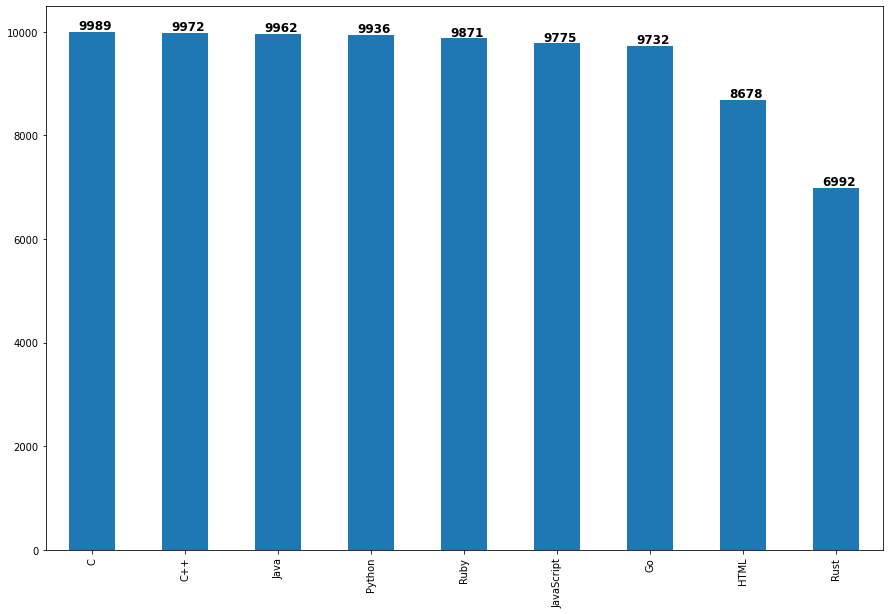

In [ ]:
data['language'].value_counts().plot(kind='bar', figsize=(15,10))
for index, value in enumerate(data['language'].value_counts().tolist()):
    plt.text(index-0.15, value+50, str(value), fontweight='bold', fontsize='large')

Rust has significantly less  snippets than other languages.

### Splitting the code snippet and the label that we will predict.

In [ ]:
X, y = data.snippet, data.language

In [ ]:
X

0        } else if (adreno_is_a640(adreno_gpu)) {\n\t\t...
1        #   endif\n\t   )\n\t{\n#   if defined(UNIX)\n...
2        static void  fit3_write_regr( PIA *pi, int con...
3        int unix_stream_listen(const char *path)\n{\n\...
4        void mlx5e_vxlan_set_netdev_info(struct mlx5e_...
                               ...                        
87017    * plain<br>\n* *emphasis*<br>\n&nbsp; * **stro...
87018    <ul class="blockList">\n<li class="blockList">...
87019    <span class="hljs-keyword">const</span> citySc...
87024    </P>\n<H2><A HREF="#toc5" NAME="sect5">Author<...
87025    </a>      </li>\n          <li>\n        <a hr...
Name: snippet, Length: 84907, dtype: object

In [ ]:
X[1]

'#   endif\n\t   )\n\t{\n#   if defined(UNIX)\n\t    if (use_xterm_mouse() > 1 && mouse_code >= 0x80)'

In [ ]:
y[1]

'C'

## Tokenization and Vectorization

In [ ]:
def preprocess(x):
    '''Function that will convert some words or sequence of characters with a generic token'''
    return pd.Series(x).replace(r'(\n)+', ' __NL__ ', regex=True).replace(r'\".+?\"|\'.+?\'', ' __s__ ', regex=True).replace(r'(\t)+', ' __TAB__ ', regex=True).replace(r'\b[\.0-9]+\b|\b(0x)[0-9a-fA-F]+\b', ' __d__ ', regex=True)

In [ ]:
X = preprocess(X) # We apply our preprocessing function to X

In [ ]:
X[0]

'} else if (adreno_is_a640(adreno_gpu)) { __NL__  __TAB__ ret = a6xx_gmu_memory_alloc(gmu, &gmu->icache, __NL__  __TAB__ SZ_256K - SZ_16K,  __d__ ); __NL__  __TAB__ if (ret) __NL__  __TAB__ goto err_memory;'

Below is the token pattern that describes what will we use as a token.
1. All words that begin with capital letter, small letter or underscore and then zero or more alphanumeric character. (This could be variable and function names, language keywords)
2. Tokens that represent an operator.
3. Tokens that represent spaces, brackets, semicolon

In [ ]:
token_pattern = r"""(\b[A-Za-z_]\w*\b|[!\#\$%\&\*\+:\-\./<=>\?@\\\^_\|\~]+|[ \(\),;\{\}\[\]`"'])"""

The vectorizer that will be used is tf-idf(term frequency-inverse document frequency). Maximum 10000 tokens will be generated, every token must appear in minimum 10 snippets for it to be a valid token. We will also take bigrams which are formed from two tokens.

In [ ]:
vectorizer = TfidfVectorizer(token_pattern=token_pattern, max_features=10000, min_df=10, ngram_range=(1,2), lowercase=False)

### Train-test split

We split the dataset in train and test datasets. The test dataset will be 20% from the original one. To remove sampling bias we make sure that the class distribution in the full dataset is observed in the test dataset also with stratification.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
y_train.value_counts()

C             7991
C++           7977
Java          7969
Python        7949
Ruby          7897
JavaScript    7820
Go            7786
HTML          6942
Rust          5594
Name: language, dtype: int64

In [ ]:
X_test.shape

(16982,)

## Training models

### Random Forest

In [ ]:
rf_clf = RandomForestClassifier(n_jobs=-1)

In [ ]:
pipe_RF = Pipeline([
    ('vectorizer', vectorizer),
    ('clf', rf_clf)]
)

In [ ]:
pipe_RF.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(lowercase=False, max_features=10000, min_df=10,
                                 ngram_range=(1, 2),
                                 token_pattern='(\\b[A-Za-z_]\\w*\\b|[!\\#\\$%\\&\\*\\+:\\-\\./<=>\\?@\\\\\\^_\\|\\~]+|[ '
                                               '\\(\\),;\\{\\}\\[\\]`"\'])')),
                ('clf', RandomForestClassifier(n_jobs=-1))])

In [ ]:
y_pred = pipe_RF.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 93.18%


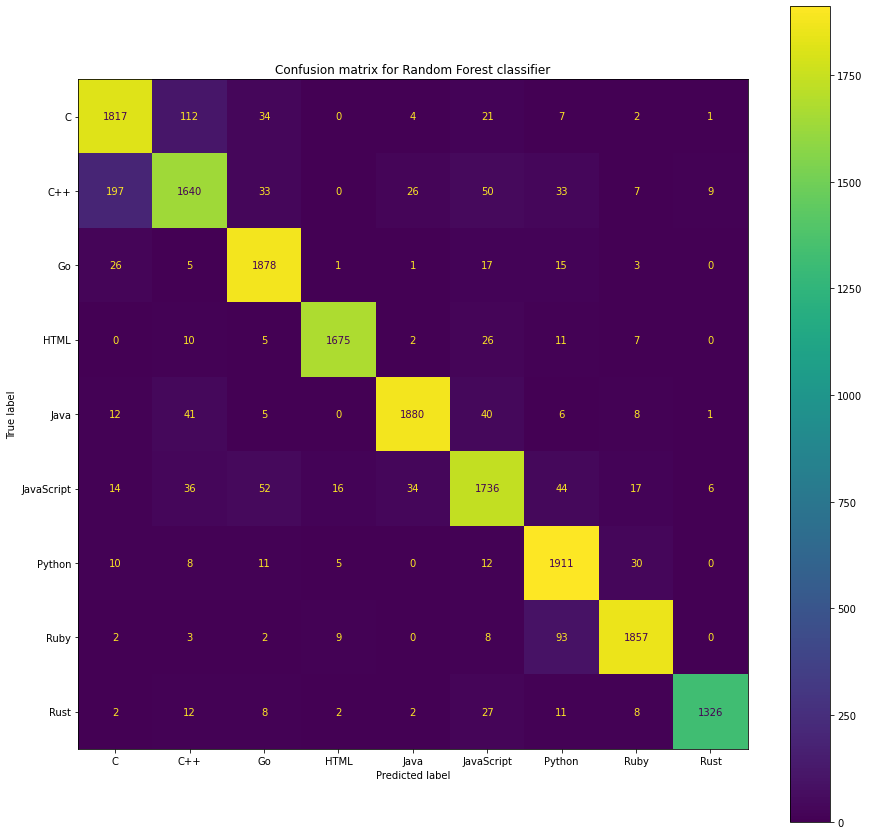

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
plt.title('Confusion matrix for Random Forest classifier')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           C       0.87      0.92      0.89      1998
         C++       0.85      0.84      0.85      1995
          Go       0.94      0.98      0.96      1946
        HTML       0.98      0.98      0.98      1736
        Java       0.98      0.93      0.95      1993
  JavaScript       0.91      0.89      0.90      1955
      Python       0.92      0.97      0.94      1987
        Ruby       0.98      0.94      0.96      1974
        Rust       0.99      0.96      0.97      1398

    accuracy                           0.93     16982
   macro avg       0.94      0.93      0.93     16982
weighted avg       0.93      0.93      0.93     16982



### Random Forest with feature selection (ANOVA F-value)

In [ ]:
selector = SP(percentile=70) #selects 70% of the best features

In [ ]:
pipe_RF2 = Pipeline([
    ('vectorizer', vectorizer),
    ('selector', selector),
    ('clf', rf_clf)]
)

In [ ]:
pipe_RF2.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(lowercase=False, max_features=10000, min_df=10,
                                 ngram_range=(1, 2),
                                 token_pattern='(\\b[A-Za-z_]\\w*\\b|[!\\#\\$%\\&\\*\\+:\\-\\./<=>\\?@\\\\\\^_\\|\\~]+|[ '
                                               '\\(\\),;\\{\\}\\[\\]`"\'])')),
                ('selector', SelectPercentile(percentile=70)),
                ('clf', RandomForestClassifier(n_jobs=-1))])

In [ ]:
y_pred = pipe_RF2.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 93.15%


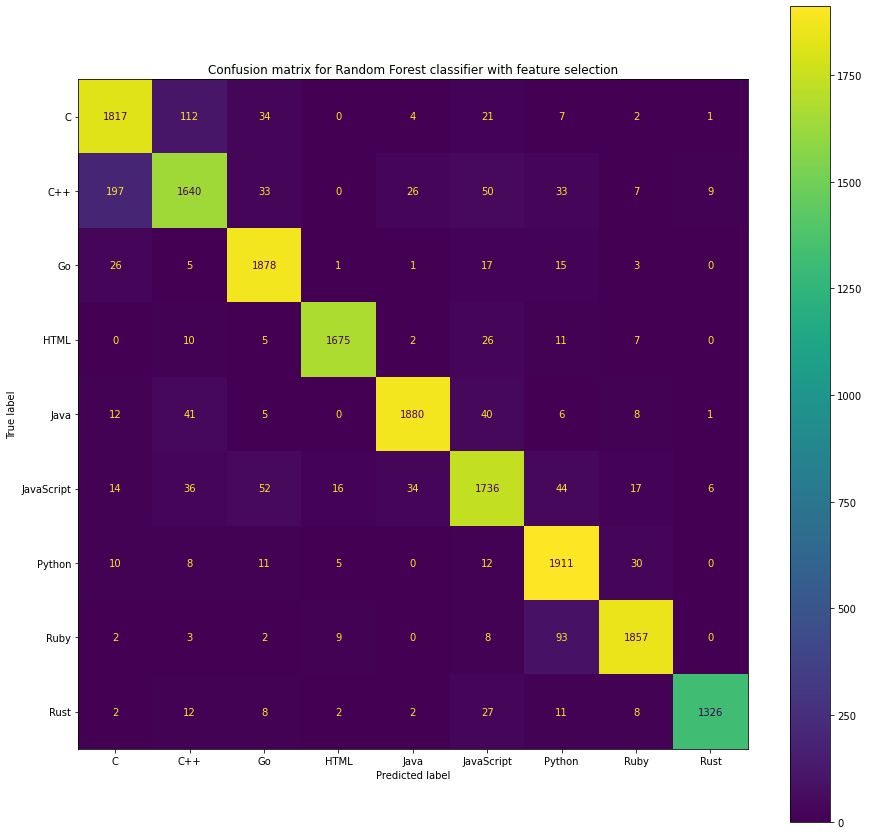

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
plt.title('Confusion matrix for Random Forest classifier with feature selection')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           C       0.87      0.92      0.89      1998
         C++       0.86      0.84      0.85      1995
          Go       0.94      0.98      0.96      1946
        HTML       0.98      0.98      0.98      1736
        Java       0.97      0.93      0.95      1993
  JavaScript       0.91      0.89      0.90      1955
      Python       0.92      0.97      0.94      1987
        Ruby       0.97      0.94      0.95      1974
        Rust       0.99      0.96      0.97      1398

    accuracy                           0.93     16982
   macro avg       0.93      0.93      0.93     16982
weighted avg       0.93      0.93      0.93     16982



### Naive Bayes

In [ ]:
nb_clf = MultinomialNB()

In [ ]:
pipe_NB = Pipeline([
    ('vectorizer', vectorizer),
    ('selector', selector),
    ('clf', nb_clf)]
)

In [ ]:
pipe_NB.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(lowercase=False, max_features=10000, min_df=10,
                                 ngram_range=(1, 2),
                                 token_pattern='(\\b[A-Za-z_]\\w*\\b|[!\\#\\$%\\&\\*\\+:\\-\\./<=>\\?@\\\\\\^_\\|\\~]+|[ '
                                               '\\(\\),;\\{\\}\\[\\]`"\'])')),
                ('selector', SelectPercentile(percentile=70)),
                ('clf', MultinomialNB())])

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 93.15%


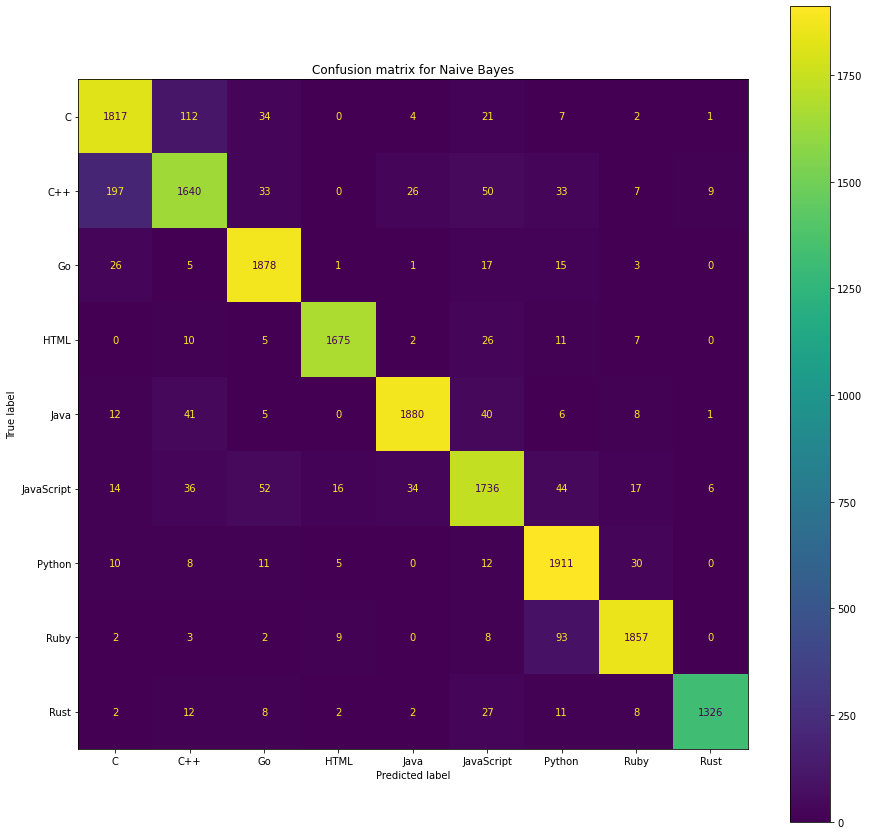

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
plt.title('Confusion matrix for Naive Bayes')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           C       0.87      0.92      0.89      1998
         C++       0.86      0.84      0.85      1995
          Go       0.94      0.98      0.96      1946
        HTML       0.98      0.98      0.98      1736
        Java       0.97      0.93      0.95      1993
  JavaScript       0.91      0.89      0.90      1955
      Python       0.92      0.97      0.94      1987
        Ruby       0.97      0.94      0.95      1974
        Rust       0.99      0.96      0.97      1398

    accuracy                           0.93     16982
   macro avg       0.93      0.93      0.93     16982
weighted avg       0.93      0.93      0.93     16982



### Gradient boosting methods

#### XGBoost

In [ ]:
XGB_clf = xgb.XGBClassifier()

In [ ]:
pipe_XGB = Pipeline([
    ('vectorizer', vectorizer),
    ('selector', selector),
    ('clf', XGB_clf)]
)


In [ ]:
start = time.time()
pipe_XGB.fit(X_train, y_train)
total = np.around(time.time() - start,2)

In [ ]:
print('Time taken to build model:', total)

Time taken to build model: 325.95


In [ ]:
y_pred = pipe_XGB.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 89.31%


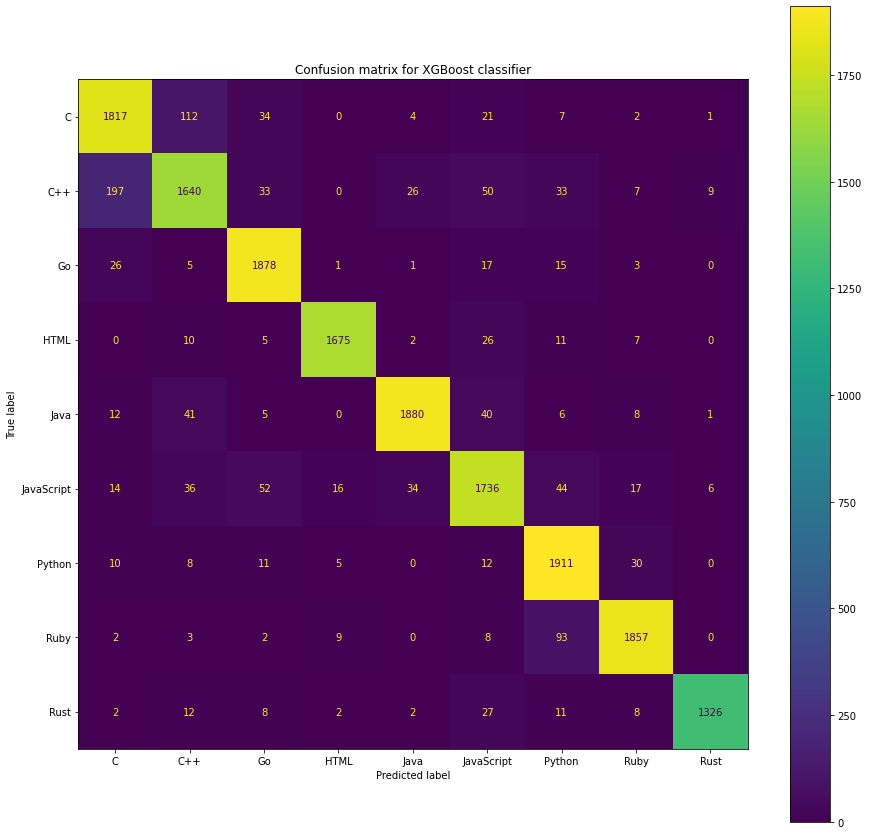

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
plt.title('Confusion matrix for XGBoost classifier')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           C       0.84      0.88      0.86      1998
         C++       0.87      0.76      0.81      1995
          Go       0.86      0.97      0.91      1946
        HTML       0.97      0.98      0.98      1736
        Java       0.94      0.90      0.92      1993
  JavaScript       0.82      0.81      0.82      1955
      Python       0.86      0.94      0.90      1987
        Ruby       0.94      0.91      0.92      1974
        Rust       0.98      0.91      0.94      1398

    accuracy                           0.89     16982
   macro avg       0.90      0.90      0.90     16982
weighted avg       0.89      0.89      0.89     16982



#### LightGBM

In [ ]:
LGBM_clf = ltb.LGBMClassifier()

In [ ]:
pipe_LGBM = Pipeline([
    ('vectorizer', vectorizer),
    ('selector', selector),
    ('clf', LGBM_clf)]
)

In [ ]:
start = time.time()
pipe_LGBM.fit(X_train, y_train)
total = np.around(time.time() - start,2)

In [ ]:
print('Time taken to build model:', total)

Time taken to build model: 323.07


In [ ]:
y_pred = pipe_LGBM.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 93.94%


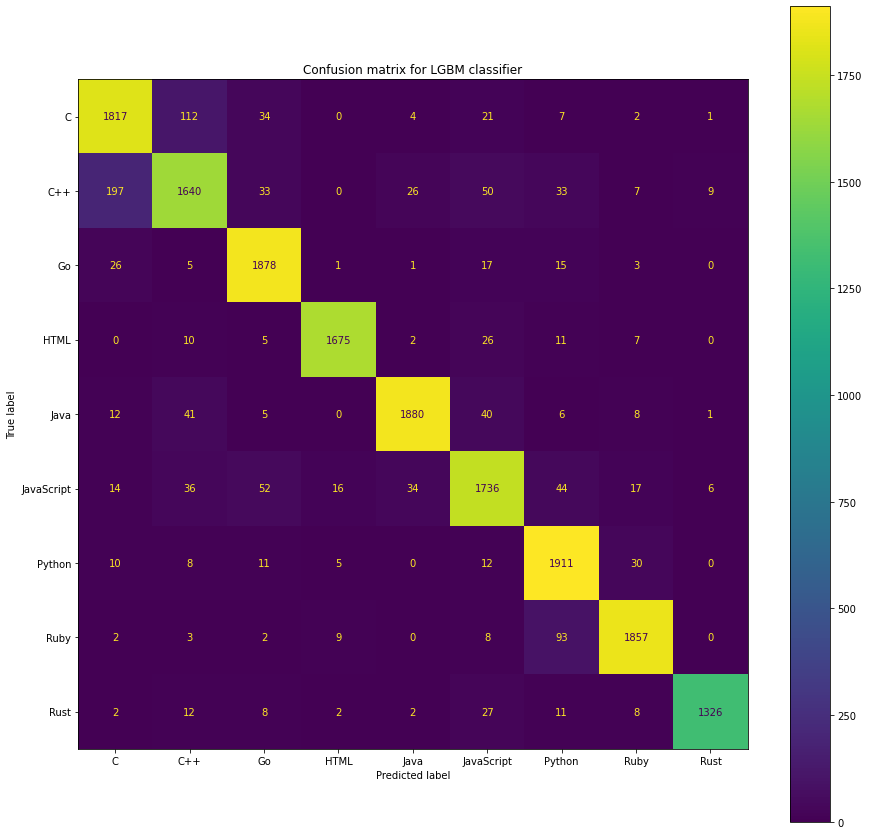

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
plt.title('Confusion matrix for LGBM classifier')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           C       0.89      0.92      0.91      1998
         C++       0.88      0.85      0.87      1995
          Go       0.96      0.97      0.97      1946
        HTML       0.98      0.99      0.99      1736
        Java       0.96      0.95      0.96      1993
  JavaScript       0.91      0.91      0.91      1955
      Python       0.93      0.96      0.94      1987
        Ruby       0.97      0.95      0.96      1974
        Rust       0.99      0.96      0.97      1398

    accuracy                           0.94     16982
   macro avg       0.94      0.94      0.94     16982
weighted avg       0.94      0.94      0.94     16982



### Logistic Regression

In [ ]:
lr_clf = linear_model.LogisticRegression(penalty='l2', C=1.0, multi_class='multinomial', max_iter=1000, n_jobs=-1)
pipe_LR = Pipeline([
    ('vectorizer', vectorizer),
    ('selector', selector),
    ('clf', lr_clf)]
)

In [ ]:
pipe_LR.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(lowercase=False, max_features=10000, min_df=10,
                                 ngram_range=(1, 2),
                                 token_pattern='(\\b[A-Za-z_]\\w*\\b|[!\\#\\$%\\&\\*\\+:\\-\\./<=>\\?@\\\\\\^_\\|\\~]+|[ '
                                               '\\(\\),;\\{\\}\\[\\]`"\'])')),
                ('selector', SelectPercentile(percentile=70)),
                ('clf',
                 LogisticRegression(max_iter=1000, multi_class='multinomial',
                                    n_jobs=-1))])

In [ ]:
y_pred = pipe_LR.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 92.57%


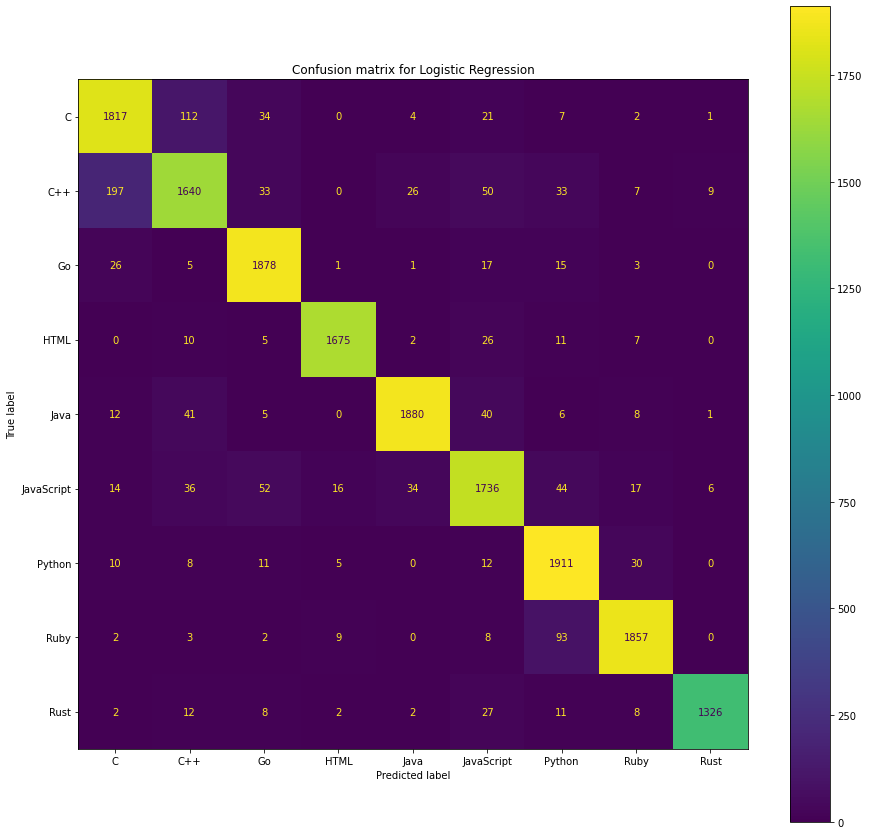

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
plt.title('Confusion matrix for Logistic Regression')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           C       0.87      0.91      0.89      1998
         C++       0.88      0.82      0.85      1995
          Go       0.93      0.97      0.95      1946
        HTML       0.98      0.96      0.97      1736
        Java       0.96      0.94      0.95      1993
  JavaScript       0.90      0.89      0.89      1955
      Python       0.90      0.96      0.93      1987
        Ruby       0.96      0.94      0.95      1974
        Rust       0.99      0.95      0.97      1398

    accuracy                           0.93     16982
   macro avg       0.93      0.93      0.93     16982
weighted avg       0.93      0.93      0.93     16982



## Model explanations with LIME

The results are great but let's take a look how the classifier is making its decisions. The module LIME generates explanations which highlight words that are most correlated with each label. This way, we have an idea why the model is choosing one label instead of another.

In [ ]:
#!pip install lime
from lime import lime_text

In [ ]:
def predictions(pred, true, y_pred, y_test):
    '''
    Function that returns list of indices in test dataset that are predicted as pred in y_pred and are true in y_test
    '''
    indices=[]
    for index, value in np.ndenumerate(y_pred):
        if value == pred:
            if y_test.iloc[index[0]] == true:
                indices.append(index[0])
    return indices

In [ ]:
explainer = lime_text.LimeTextExplainer(class_names=pipe_LGBM.classes_)

In [ ]:
idx = np.random.randint(0,X_test.shape[0])
item = y_pred[idx]

In [ ]:
exp = explainer.explain_instance(X_test.iloc[idx], pipe_LGBM.predict_proba, num_features=7, labels=[np.where(pipe_LGBM.classes_ == item)[0][0]])

In [ ]:
exp.show_in_notebook()

As we can see from all confusion matrices, the biggest mistake that the classifiers are making is that they are misclassifying the languages C and C++.
Probably this is because C++ is a superset of C.

Let's look at an example.

In [ ]:
indices = predictions('C++', 'C', y_pred, y_test)

In [ ]:
idx = np.random.choice(indices)
item = y_pred[idx]

In [ ]:
exp = explainer.explain_instance(X_test.iloc[idx], pipe_LGBM.predict_proba, num_features=7, labels=[np.where(pipe_LGBM.classes_ == item)[0][0]])

In [ ]:
exp.show_in_notebook()